# Import

In [11]:
import torch
import torchvision

# Models

In [12]:
from glcic.networks.completion_network import CompletionNetwork
from glcic.networks.discriminators import Discriminator

In [13]:
# import the completion network
cn = CompletionNetwork()
cn.load("../logs/models/cn_scrapped_weights")

# import the discriminator
discriminator = Discriminator()
checkpoint = torch.load("../logs/remote_phase2_checkpoints/202309281719")
discriminator.load_state_dict(checkpoint['cn'])

Load: load_state dict from ../logs/models/cn_scrapped_weights


<All keys matched successfully>

# Dataset

In [14]:
# # choose a random test dir
# import os
# import random
# random_dir = random.choice(os.listdir('../data/val/'))

In [15]:
# load the dataset
test_dataset_dir = '../data/val/'
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_dir, transform=torchvision.transforms.ToTensor())
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# first batch
batch = next(iter(test_dataloader))[0]

# Test

In [16]:
# mask
from glcic.utils import *

lm,em = generate_mask(4)
replacement_val = torch.rand(3)
masked_batch = apply_mask(batch,em,replacement_val)

In [17]:
# complete
cn.eval()
_em = em[:,None,:,:]
with torch.no_grad():
    completed = cn(torch.cat((masked_batch,_em),dim=1))
completed = torch.where(_em,completed,masked_batch)
postprocessed = postprocess(completed,em,lm)

In [18]:
# discriminate
discriminator.eval()
with torch.no_grad():
    real_preds = discriminator(batch, lm)
    fake_pred = discriminator(postprocessed, lm)

# Display

The discriminator predicts 1.0 for the original image and 1.0 for the fake image.


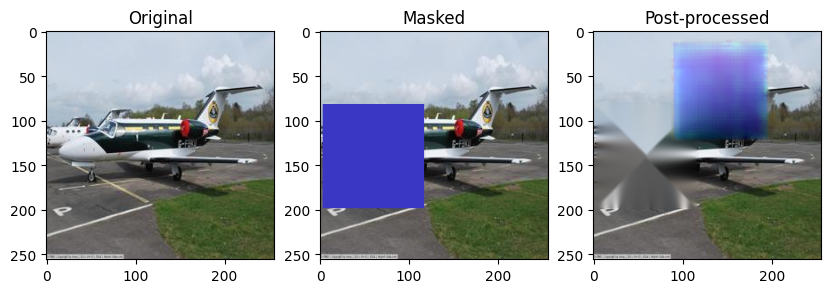

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(10, 15))

# display the original image
axes[0].imshow(batch[0].permute(1,2,0))
axes[0].set_title('Original')

# display the masked image
axes[1].imshow(masked_batch[0].permute(1,2,0))
axes[1].set_title('Masked')

# post-processed
axes[2].imshow(postprocessed[0].permute(1,2,0))
axes[2].set_title('Post-processed')

print("The discriminator predicts {} for the original image and {} for the fake image.".format(float(real_preds[0]), float(fake_pred[0])))